# Pollen Identifier
The goal of this script is to: 

1) identify pollen from the slide background 

2) calculate the area of the pollen grain

The data come from `https://www.paldat.org/`and were taken from species within the _Poales_ group that had light microscopy images (rather than electron microscope images)

## Preprocessing and thresholding the pollen images
Using the opencv thresholding tutorial: `https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html`
This will allow us to cut out the pollen grains from the background of the image

In [1]:
#importing necessary libraries and 2 test images
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img1 = cv.imread('1_Alopecurus_pratensis.jpg')
img2 = cv.imread('2_Alopecurus_pratensis.jpg')

In [2]:
#check to see that the images are the same size
print(img1.shape)
print(img2.shape)

(192, 240, 3)
(192, 240, 3)


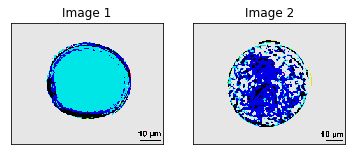

In [4]:
#This does the thresholding, keeps the results in thresh# object
ret, thresh1 = cv.threshold(img1, 180,230,cv.THRESH_BINARY)
ret, thresh2 = cv.threshold(img2, 180,230,cv.THRESH_BINARY)

#comparing the results side by side in a subplot
titles = ["Image 1","Image 2"]
images = [thresh1, thresh2]

for i in range(2):
    plt.subplot(1,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    
plt.show()

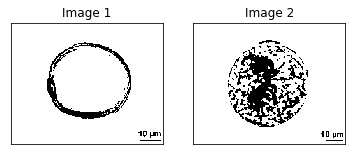

In [5]:
#Trying them as grayscale instead of color images, all other parts stay the same
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

ret, thresh1 = cv.threshold(gray1, 180,230,cv.THRESH_BINARY)
ret, thresh2 = cv.threshold(gray2, 180,230,cv.THRESH_BINARY)

titles = ["Image 1","Image 2"]
images = [thresh1, thresh2]

for i in range(2):
    plt.subplot(1,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    
plt.show()

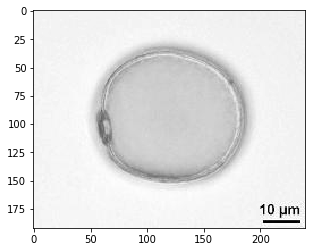

In [6]:
plt.imshow(gray1, cmap="gray")
plt.show()

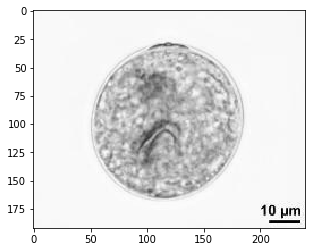

In [7]:
plt.imshow(gray2, cmap="gray")
plt.show()

To figure out which pixel values would be the best for thresholding, I created these histograms to see where there were peaks for pixel values

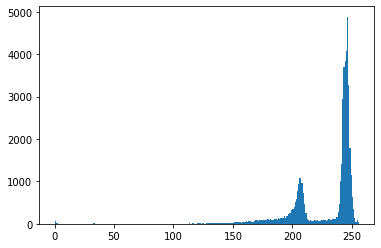

In [8]:
plt.hist(gray1.ravel(),256,[0,256]); plt.show()

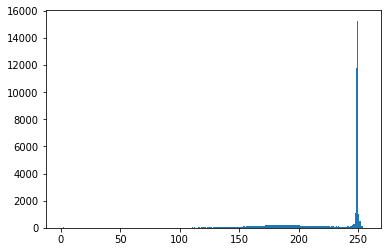

In [9]:
plt.hist(gray2.ravel(),256,[0,256]); plt.show()

Here I test the use of a gaussian blur on the outcomes of the thresholding.

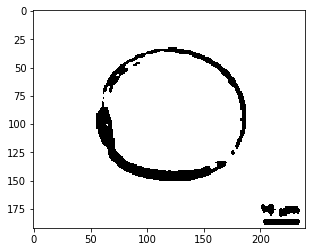

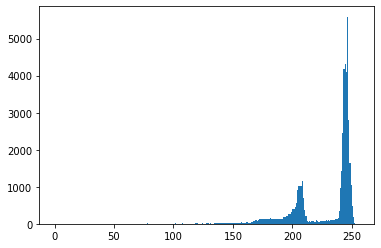

In [10]:
gray1 = cv.GaussianBlur(gray1, (7,7),0)
ret, thresh1 = cv.threshold(gray1, 180,230,cv.THRESH_BINARY)
plt.imshow(thresh1,'gray')
plt.show()
plt.hist(gray1.ravel(),256,[0,256]); plt.show()

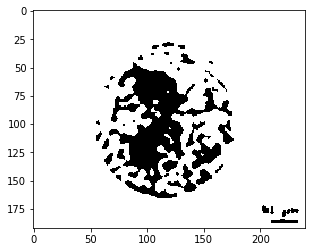

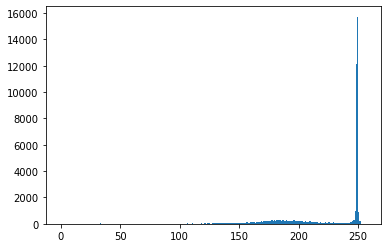

In [11]:
gray2 = cv.medianBlur(gray2, 5)
ret, thresh2 = cv.threshold(gray2, 180,230,cv.THRESH_BINARY)
plt.imshow(thresh2,'gray')
plt.show()
plt.hist(gray2.ravel(),256,[0,256]); plt.show()

To cut out only those pixels related to the pollen grain, I need to create a mask based on the thresholds. The following is how I do that.

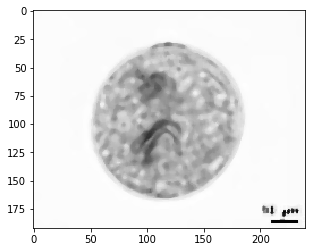

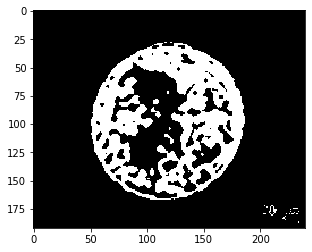

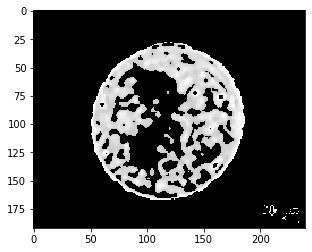

In [12]:
mask = cv.inRange(gray2, 180,230)
res = cv.bitwise_and(gray2,gray2, mask=mask)
plt.imshow(gray2,'gray');plt.show()
plt.imshow(mask, 'gray'); plt.show()
plt.imshow(res, 'gray'); plt.show()

## Extracting features
Now that the images have been thresholded and I know how to creat a mask around the grain, I need to measure features related to the grain. I do this by creating contours around each grain, filling in the contours, and then extracting features from them. 

This is done using the tutorials found at `https://docs.opencv.org/trunk/d3/d05/tutorial_py_table_of_contents_contours.html`

Further advice and thoughts were adapted from `https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/` to do the filling in of the contours.

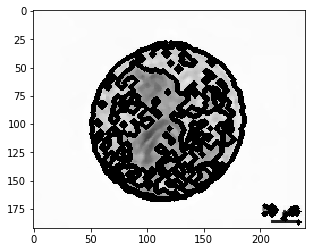

In [13]:
#finding the contours
#must be done after thresholding
contours2, hierarchy = cv.findContours(res, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(gray2, contours2, -1, (0,255,0),3)
plt.imshow(gray2,'gray');plt.show()
#cnt = contours2[1]
#cv.drawContours(gray2,[cnt],0,(0,255,0),3)

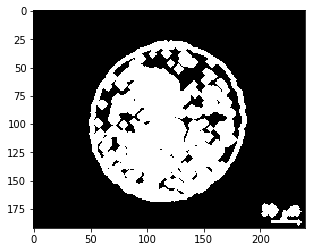

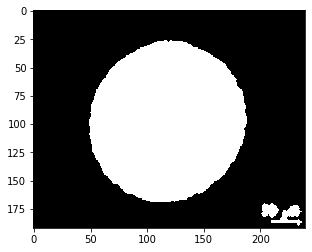

In [15]:
#advice from `https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/`
ret, thresh2 = cv.threshold(gray2, 180,230,cv.THRESH_BINARY_INV)
plt.imshow(thresh2,'gray');plt.show()

#Make a copy of the image to work with in floodfill
im_floodfill =thresh2.copy()
#mask used for floodfilling, needs to be 2 pixels larger than the image
h, w = thresh2.shape[:2]
mask2 = np.zeros((h+2,w+2),np.uint8)
#floodfill from point (0,0)
cv.floodFill(im_floodfill, mask2,(0,0),255)
#invert the floodfill image
im_floodfill_inv = cv.bitwise_not(im_floodfill)
#combine the two images to get the foreground
im_out = thresh2.astype(np.int) | im_floodfill_inv.astype(np.int)
#display images
plt.imshow(im_out,'gray'); plt.show()


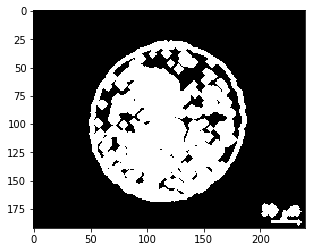

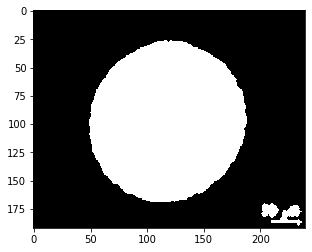

In [16]:
#Trying the same thing as the above cell, 
#but using the mask created in the last step of the thresholding chunk to be the mask used for floodfilling
ret, thresh2 = cv.threshold(gray2, 180,230,cv.THRESH_BINARY_INV)
plt.imshow(thresh2,'gray');plt.show()

#Make a copy of the image to work with in floodfill
im_floodfill =thresh2.copy()
#mask used for floodfilling, needs to be 2 pixels larger than the image
h, w = mask.shape[:2]
mask2 = np.zeros((h+2,w+2),np.uint8)
#floodfill from point (0,0)
cv.floodFill(im_floodfill, mask2,(0,0),255)
#invert the floodfill image
im_floodfill_inv = cv.bitwise_not(im_floodfill)
#combine the two images to get the foreground
im_out = thresh2.astype(np.int) | im_floodfill_inv.astype(np.int)
#display images
plt.imshow(im_out,'gray'); plt.show()


In [28]:
type(im_out) #structure of im_out
#cv.minMaxLoc(im_out) #the min pixel value, max, loc of min, loc of max
print(im_out.dtype)
trial = np.float32(im_out)
print(trial.dtype)

int64
float32


In [50]:
#This gives us the ratio from all white pixels in the floodfilled image `https://stackoverflow.com/questions/58068315/calculate-the-area-of-the-masks-in-pixels-in-grey-scale-images-with-python`
pixels = cv.countNonZero(trial)
print(pixels)
image_area = trial.shape[0] * trial.shape[1]
area_ratio = (pixels /image_area) * 100
print(area_ratio)

15691
34.05164930555556


(192, 240)


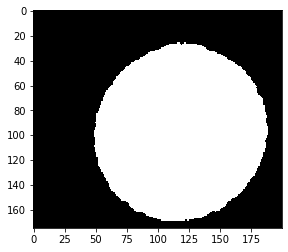

In [59]:
#Need to remove the error bar while pixel area is being calculated
print(trial.shape)
crop_trial = trial[0:175,0:200]
plt.imshow(crop_trial, 'gray'); plt.show()

In [60]:
pixels = cv.countNonZero(crop_trial)
print(pixels)
image_area = crop_trial.shape[0] * crop_trial.shape[1]
area_ratio = (pixels /image_area) * 100
print(area_ratio)

15327
43.79142857142857


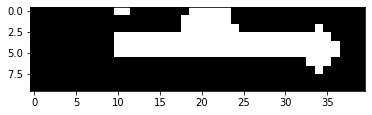

(10, 40)


In [64]:
eb_trial = trial[182:192,200:240]
plt.imshow(eb_trial, 'gray'); plt.show()
print(eb_trial.shape)

In [72]:
#for each row of pixels
    #count the number of non-zeros and sum 
#pick the maximum sum

c=np.empty((0,10))
for i in range(eb_trial.shape[0]):
    a = eb_trial[i,0:40]/255
    b = sum(a)
    c=np.append(c,b)
print(c)
max(c)

[ 7.  6.  8. 26. 27. 27.  3.  1.  0.  0.]


27.0

In [74]:
pixelsperum = max(c)/10 #uses the error bar's length as reference
image_area_um = (crop_trial.shape[0]/pixelsperum)*(crop_trial.shape[1]/pixelsperum)
object_area_um = pixels/pixelsperum
area_ratio_um = (object_area_um /image_area_um) * 100
print(area_ratio_um) #This is in micro meters squared now because it's from an area

118.23685714285712
